In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

2025-08-02 23:02:58.526314: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 23:02:58.553618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-02 23:02:58.601780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-02 23:02:58.601839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 23:02:58.636988: I tensorflow/core/platform/cpu_feature_gua

In [2]:
X_train = r"/mnt/d/Users/rusha/rusha/Downloads/CUB_200_2011/CUB_200_2011/images"

In [3]:
images = pd.read_csv("/mnt/d/Users/rusha/rusha/Downloads/CUB_200_2011/CUB_200_2011/images.txt", sep=' ', names=['image_id', 'image_name'])
labels = pd.read_csv("/mnt/d/Users/rusha/rusha/Downloads/CUB_200_2011/CUB_200_2011/image_class_labels.txt", sep=' ', names=['image_id', 'class_id'])
split = pd.read_csv("/mnt/d/Users/rusha/rusha/Downloads/CUB_200_2011/CUB_200_2011/train_test_split.txt", sep=' ', names=['image_id', 'is_training_image'])
bboxes = pd.read_csv("/mnt/d/Users/rusha/rusha/Downloads/CUB_200_2011/CUB_200_2011/bounding_boxes.txt", sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])

df = images.merge(labels,on='image_id').merge(split, on='image_id').merge(bboxes, on='image_id')
df.head()

,image_id,image_name,class_id,is_training_image,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,60.0,27.0,325.0,304.0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,139.0,30.0,153.0,264.0
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,14.0,112.0,388.0,186.0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,112.0,90.0,255.0,242.0
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,70.0,50.0,134.0,303.0


In [4]:
# from PIL import Image

# img = Image.open(os.path.join(X_train, df.iloc[1]['image_name']))
# x,y,w,h = df.iloc[0][['x', 'y', 'width', 'height']]
# img_cropped = img.crop((x, y, x + w, y + h))
# img_cropped.show()

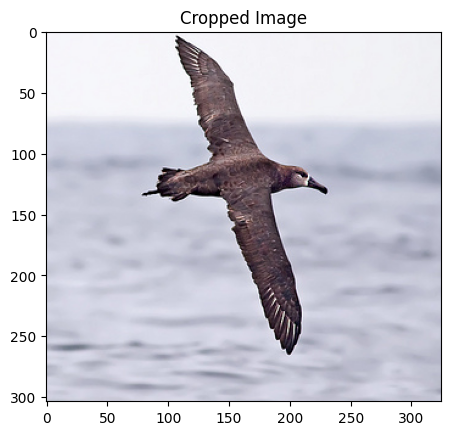

In [5]:
img = mpimg.imread(os.path.join(X_train, df.iloc[1]['image_name']))

x, y, w, h = map(int, df.iloc[0][['x', 'y', 'width', 'height']])
img_cropped = img[y:y+h, x:x+w]

# plt.axis('off')
plt.imshow(img_cropped)
plt.title("Cropped Image")
plt.show()

In [6]:
df = images.merge(labels, on='image_id').merge(bboxes, on='image_id').merge(split, on='image_id')
# df['image_id'] = df['image_name'].apply(lambda name: os.path.join(X_train, name))

In [7]:
train_df = df[df['is_training_image']==1].reset_index(drop=True)
test_df = df[df['is_training_image']==0].reset_index(drop=True)
print(train_df.shape, test_df.shape)

(5994, 8) (5794, 8)


In [8]:
train_df.loc[:,'class_id'] = train_df.loc[:,'class_id'] - 1
test_df.loc[:,'class_id'] = test_df.loc[:,'class_id'] - 1

train_df['image_path'] = train_df['image_name'].apply(lambda name: os.path.join(X_train, name))
test_df['image_path'] = test_df['image_name'].apply(lambda name: os.path.join(X_train, name))

In [9]:
def save_images(df, subset_name):
    for _, row in df.iterrows():
        class_folder = f"data/{subset_name}/{row['class_id']}"
        os.makedirs(class_folder, exist_ok=True)
        src = row['image_path']
        dst = os.path.join(class_folder, os.path.basename(row['image_path']))
        shutil.copy(src, dst)

save_images(train_df, "train")
save_images(test_df, "validation")

In [10]:
IMG_SIZE = 110

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE,IMG_SIZE])
    # image = image/255.0
    return image, label

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways, but not always
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.2),
])

def augment_img(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # optional safety
    image = data_augmentation(image)
    return image, label

In [13]:
train_ds = keras.utils.image_dataset_from_directory(
    "data/train",
    label_mode='int',
    batch_size=8,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
)

validation_ds = keras.utils.image_dataset_from_directory(
    "data/validation",
    label_mode='int',
    batch_size=8,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
)

Found 5994 files belonging to 200 classes.
Found 5794 files belonging to 200 classes.


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

# Apply augmentation to training set only
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras.applications import ResNet50

In [16]:
conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [17]:
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 116, 116,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 55, 55,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 55, 55,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 55, 55,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 57, 57,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 28, 28,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 28, 28,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 28, 28,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 28, 28,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 28, 28,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 28, 28,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 28, 28,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 28, 28,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 28, 28,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 28, 28,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 28, 28,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(200, activation='softmax'))

In [19]:
conv_base.trainable = False

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_ds, 
                    validation_data=validation_ds,
                    epochs=15)

Epoch 1/15


I0000 00:00:1754157293.277024   25122 service.cc:145] XLA service 0x7ca7c0013be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754157293.277923   25122 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-02 23:24:53.504767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-02 23:24:55.894893: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-08-02 23:25:00.735894: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[8,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,256,28,28]{3,2,1,0}, f32[64,256,1,1]{3,2,1,0}, f32[64]{0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_o

747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0059 - loss: 5.4977

2025-08-02 23:26:03.530017: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k2=1,k4=2,k5=1,k6=0,k7=0} for conv (f32[2,2048,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,1024,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}, f32[2048]{0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-08-02 23:26:04.161126: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.631223702s
Trying algorithm eng18{k2=1,k4=2,k5=1,k6=0,k7=0} for conv (f32[2,2048,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,1024,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}, f32[2048]{0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

750/750 ━━━━━━━━━━━━━━━━━━━━ 127s 139ms/step - accuracy: 0.0043 - loss: 5.3424 - val_accuracy: 0.0052 - val_loss: 5.2987
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 73ms/step - accuracy: 0.0025 - loss: 5.3029 - val_accuracy: 0.0052 - val_loss: 5.2986
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.0022 - loss: 5.3010 - val_accuracy: 0.0052 - val_loss: 5.2985
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.0022 - loss: 5.3007 - val_accuracy: 0.0048 - val_loss: 5.2985
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.0030 - loss: 5.3009 - val_accuracy: 0.0050 - val_loss: 5.2985
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.0042 - loss: 5.3008 - val_accuracy: 0.0052 - val_loss: 5.2983
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.0025 - loss: 5.3009 - val_accuracy: 0.0052 - val_loss: 5.2984
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.0025 - loss: 5.3007 - val_accur

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,105,882 (187.32 MB)

 Trainable params: 8,506,056 (32.45 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 17,012,114 (64.90 MB)

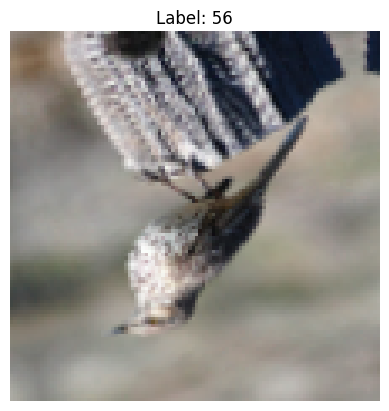

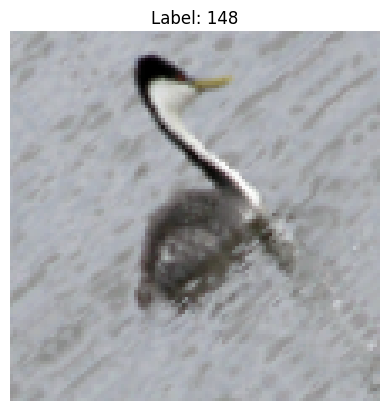

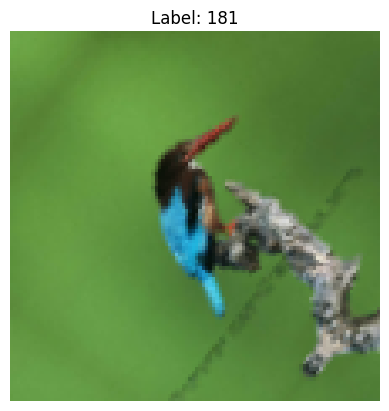

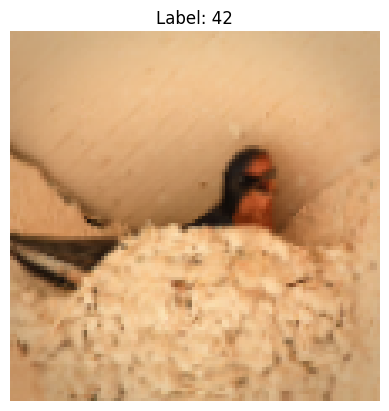

2025-08-02 23:34:46.949752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
for images, labels in train_ds.take(1):
    for i in range(4):
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

In [29]:
def compute_iou_tf(box1, box2):
    # Convert and reshape to (4,) if needed
    box1 = tf.reshape(tf.convert_to_tensor(box1, dtype=tf.float32), [4])
    box2 = tf.reshape(tf.convert_to_tensor(box2, dtype=tf.float32), [4])
    
    # (x_center, y_center, w, h) → (x1, y1, x2, y2)
    x1 = box1[0] - box1[2]/2
    y1 = box1[1] - box1[3]/2
    x2 = box1[0] + box1[2]/2
    y2 = box1[1] + box1[3]/2

    x1_gt = box2[0] - box2[2]/2
    y1_gt = box2[1] - box2[3]/2
    x2_gt = box2[0] + box2[2]/2
    y2_gt = box2[1] + box2[3]/2

    xi1 = tf.maximum(x1, x1_gt)
    yi1 = tf.maximum(y1, y1_gt)
    xi2 = tf.minimum(x2, x2_gt)
    yi2 = tf.minimum(yi2 := y2_gt, y2)  # assign and use

    inter_area = tf.maximum(xi2 - xi1, 0) * tf.maximum(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)

In [30]:
for x, y_true in validation_ds:
    y_pred = model.predict(x)

    for i in range(len(x)):
        pred_box = y_pred[i]  # should be 4 values: x_c, y_c, w, h
        true_box = y_true[i]  # same format
        iou = compute_iou_tf(pred_box, true_box)
        print(f"IoU for image {i}: {iou.numpy():.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


2025-08-03 00:05:13.694004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 200 values, but the requested shape has 4


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 200 values, but the requested shape has 4 [Op:Reshape]

In [34]:
y_true = []
y_scores = []

for images, labels in validation_ds:
    probs = model.predict(images)  # shape: [batch_size, num_classes] or [batch_size, 1]
    y_scores.extend(probs)         # for binary: probs.squeeze()
    y_true.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━

2025-08-03 00:23:36.732154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
x_test = []
y_test = []

for images, labels in validation_ds:
    x_test.append(images)
    y_test.append(labels)

# Concatenate batches into full arrays
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Now you can call:
y_scores = model.predict(x_test)

2025-08-03 00:33:10.141837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step


182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step


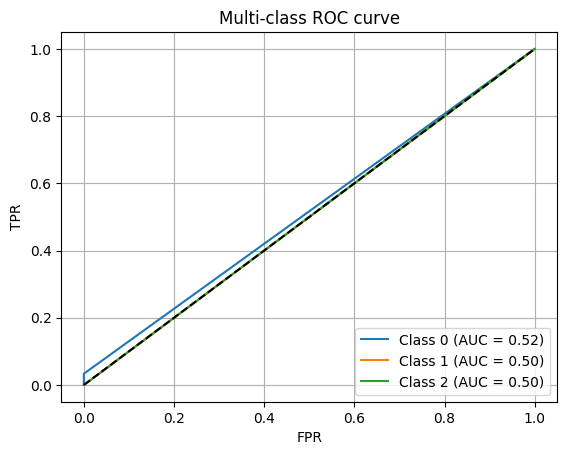

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Suppose 3 classes
n_classes = 3
y_true = label_binarize(y_true, classes=[0, 1, 2])
y_scores = model.predict(x_test)  # shape: [n_samples, 3]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Multi-class ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
